# Let's dive deep ! An image classification case
In this tutorial, we experiment usefull deep learning tools (PyTorch Lightning and Tensorboard) for a classification task on a standard dataset, the CIFAR10. We meet convolutional networks that are powerful algorithms for image analysis, and implement a lightweight VGG like architecture to solve the CIFAR10 classification task.

The CIFAR10 dataset has 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

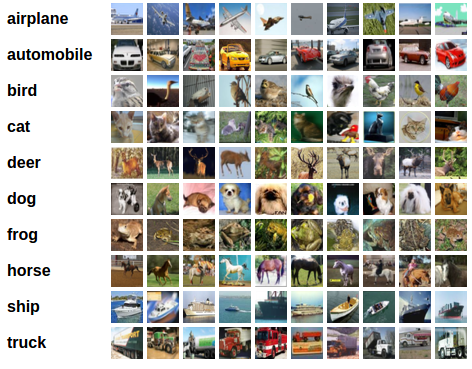

More information can be found here: https://www.cs.toronto.edu/~kriz/cifar.html

## Step 1: Prepare the environment

In [ ]:
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

import pytorch_lightning as pl

import torchvision
from torchvision import transforms
# This class loads the CIFAR10 data in a PyTorch Dataset object
# https://pytorch.org/vision/stable/datasets.html#cifar
from torchvision.datasets import CIFAR10

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define computing device
use_cuda = True

if torch.cuda.is_available and use_cuda:
    print('We have GPU !')
    gpu = 1
else:
    print('We will use CPU')
    gpu = 0

In [ ]:
# Fix random seed for reproducibility
pl.trainer.seed_everything(0)

In [ ]:
student_name = ?

## Step 2: Collect and prepare the data

In [ ]:
class CIFARDataModule(pl.LightningDataModule):

    def __init__(
        self,
        batch_size: int = 4,
    ):
        super().__init__()
        
        self.batch_size = batch_size
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        
        # The output of torchvision datasets are PILImage images of range [0, 1]. 
        # We transform them to Tensors of normalized range [-1, 1].
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
        self.cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
        len_train = int(len(dataset)*0.8)
        self.cifar_train, self.cifar_val = random_split(dataset, [len_train, len(dataset) - len_train])
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=self.batch_size, 
                          num_workers=4, pin_memory=True, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=self.batch_size, 
                          num_workers=4, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=self.batch_size, 
                          num_workers=4, pin_memory=True)


### Let us show some of the training images, for fun.

In [ ]:
data_module = CIFARDataModule()

In [ ]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(data_module.train_dataloader())
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % data_module.classes[labels[j]] for j in range(data_module.batch_size)))

# free some memory
del data_module

## Step 3: Prepare the neural network and the Lightning module
To solve the CIFAR10 classification task, we can implement the following lightweight VGG like architecture. 

The first part of the model, called the encoder, is composed of a series of 3 convolutional blocks. A convolutional block consists of 2 convolutions (including the leakyReLU activation) and 1 max pooling operation. The number of feature maps produced by each layer remains the same for the whole block.

Then, a global average pooling operation shrinks each output feature maps of the encoder to 1 pixel feature maps. This allows reducing the size of the latent representation produced by the encoder.

Finally, a fully connected layer computes from the latent representation the output value for each of the 10 classes of CIFAR10.

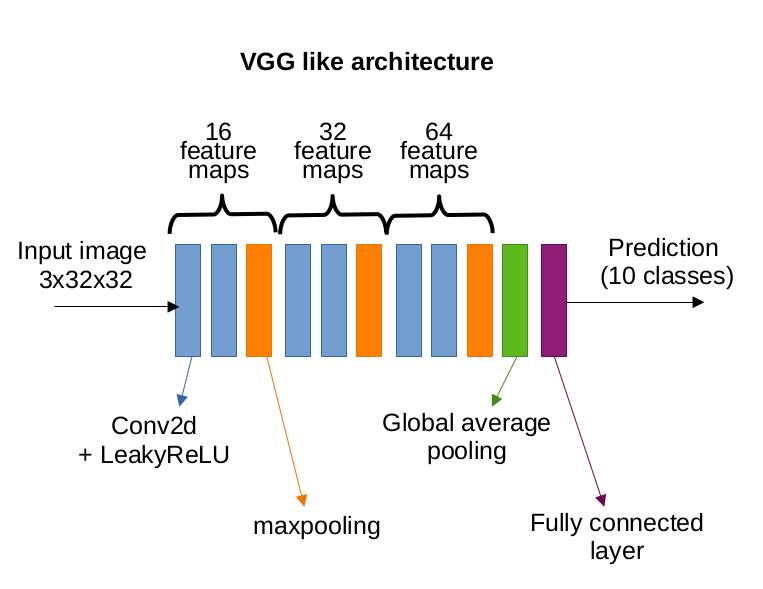

### Exercises
1. Complete the definition of the convolutional encoder of our VGG like architecture in the LightningModule class.
2. Fill the missing values in the definition of the decoder.
3. Optional (if you have a GPU): find the number of epochs that let the model reach the validation loss plateau.
4. Optional (if you have a GPU): tweak the architecture to improve the test accuracy, by adding more convolution blocks or by increasing the number of neurons. Can you do better than 0.77 ? What is the impact on the training time ?

In [ ]:
class CIFARClassifier(pl.LightningModule):

    def __init__(
        self,
        learning_rate: float = 0.0001,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        # VGG like network
        self.encoder = torch.nn.Sequential(  
            # Convolution Block 1
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            ?
            ?
            ?
            ?
            ?
            ?
            
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features= ? , out_features= ? ),  
        )
        
        self.accuracy = Accuracy()
        
    def forward(self, x):
        # use forward for inference/predictions
        x = self.encoder(x)
        x = torch.mean(x, dim=(2, 3)) # global average pooling
        x = self.decoder(x)
        x = F.softmax(x, dim=1)  # Transform network outputs into probabilities       
        return x

    def training_step(self, batch, batch_idx):
        # Function called by Lightning for each iteration
        x, y = batch
        x = self.encoder(x)
        x = torch.mean(x, dim=(2, 3))  # global average pooling
        y_hat = self.decoder(x)
        loss = F.cross_entropy(y_hat, y)  # Includes a LogSoftmax and the NegativeLogLikelihood loss
        acc = self.accuracy(F.softmax(y_hat, dim=1), y)
        self.log('Loss', {'train_loss': loss}, on_step=False, on_epoch=True)
        self.log('Accuracy', {'train_accuracy': acc}, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = self.encoder(x)
        x = torch.mean(x, dim=(2, 3))  # global average pooling
        y_hat = self.decoder(x)
        loss = F.cross_entropy(y_hat, y)  # Includes a LogSoftmax and the NegativeLogLikelihood loss
        acc = self.accuracy(F.softmax(y_hat, dim=1), y)
        self.log('Loss', {'val_loss': loss}, loss)
        self.log('Accuracy', {'val_accuracy': acc}, acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = self.encoder(x)
        x = torch.mean(x, dim=(2, 3))  # global average pooling
        y_hat = self.decoder(x)
        loss = F.cross_entropy(y_hat, y)  # Includes a LogSoftmax and the NegativeLogLikelihood loss
        acc = self.accuracy(F.softmax(y_hat, dim=1), y)
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)

    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [scheduler]


## Step 4: Define training hyperparameters

In [ ]:
# Loss function defined in the Lightning module
# optimizer defined in the Lightning module
# scheduler defined in the Lightning module

learning_rate = 0.001
# The dataset doesn't fit on the GPU memory, we need mini-batch gradient descent
batch_size = 32  # Change if needed

max_epochs = 3

## Step 5: Train the network

In [ ]:
data_module = CIFARDataModule(batch_size=batch_size)
net_module = CIFARClassifier(learning_rate=learning_rate)

In [ ]:
trainer = pl.Trainer(default_root_dir='./lightning_logs/T4_' + student_name, gpus=gpu, max_epochs=max_epochs)

# Log network graph to Tensorboard
trainer.logger.experiment.add_graph(net_module, torch.rand(batch_size, 3, 32, 32))

In [ ]:
# Lightning offers debugging capabilities. Here, we run the training and validating loops
# for only 1 batch. We can thus detect bugs without running a full epoch.
debug_trainer = pl.Trainer(fast_dev_run=True)
debug_trainer.fit(net_module, data_module)

In [ ]:
# Let Lightning train the network
trainer.fit(net_module, data_module)

### Training results

In [ ]:
! tensorboard --logdir=./lightning_logs

## Step 6: Test the model

In [ ]:
trainer.test()

### Let us check the prediction on some test images

In [ ]:
# get some random training images
n_img = 8
dataiter = iter(data_module.test_dataloader())
images, labels = dataiter.next()
with torch.no_grad():
    predictions = net_module(images)
predicted_labels = torch.argmax(predictions, dim=1)

# show images
imshow(torchvision.utils.make_grid(images[:n_img]))
# print labels
print('Predictions')
print(' '.join('%5s' % data_module.classes[pred_lab] for pred_lab in predicted_labels[:n_img]))
print('True classes')
print(' '.join('%5s' % data_module.classes[true_lab] for true_lab in labels[:n_img]))

## Do you need a "solution" ?
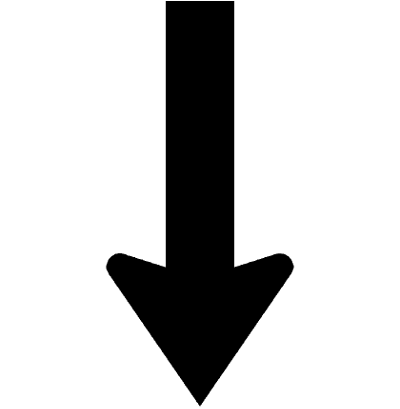

### Hints

* Beware of the number of input_channels or input_features of the layers.
* Check the scheduler step size to have an idea of the required number of epochs ;-)
* If you change the batch size, don't forget to change the learning accordingly, e.g., batch_size / 2 -> lr / 2

### Solution
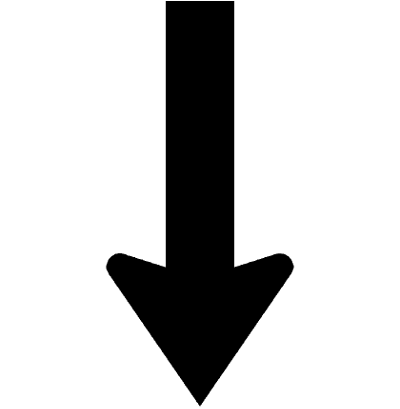

In [ ]:
# VGG like network
self.encoder = torch.nn.Sequential(  
    torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2)
)
self.decoder = torch.nn.Sequential(
    torch.nn.Linear(in_features=64, out_features=10),
)

# Number of epochs to reach the plateau. !! Valid for a batch size of 32 and a learning rate of 0.001 !!
max_epochs = 15